# Model 2
### Project: Exploring Trends in US Happiness with Census Data
Team Members: Taylor Witte, Donald Yu, Praveen Manimaran, Vitush Agarwal, Parker Aman

UCSD Spring 2024 232R Big Data Analytics Using Spark 


## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, element_at, udf
from pyspark.sql.functions import explode
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import when
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, PCAModel
from pyspark.sql.types import ArrayType, DoubleType, NumericType
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

## Import Datasets

### Import World Happiness Data

In [2]:
# Import necessary modules
from pyspark.sql import SparkSession

# Create a SparkSession object
spark = SparkSession.builder \
    .appName("BigDataGroupProject") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
#World Happiness Data
world_happiness = pd.read_csv("World Happiness Report.csv")

# Filter for USA & years of cencus data
US_happiness =  world_happiness.loc[world_happiness['Country Name'] == 'United States']
US_happiness = US_happiness[US_happiness.Year >= 2012]
US_happiness = US_happiness[US_happiness.Year != 2020]


In [4]:
#World Happiness Results 
happiness_rank = pd.read_csv("World_Happiness_Index.csv")

# Filter for USA & years of cencus data
happiness_rank = happiness_rank.loc[happiness_rank['Country'] == 'United States']
happiness_rank = happiness_rank[happiness_rank.Year != 2023]
happiness_rank = happiness_rank[happiness_rank.Year != 2020]
happiness_rank = happiness_rank.rename(columns={'Country': 'Country Name', 'Year':'Year','Index':'Happiness_Index',
                       'Rank':'Happiness_Rank'})
happiness_rank

,Country Name,Year,Happiness_Index,Happiness_Rank
1444,United States,2013,7.082,17
1445,United States,2015,7.119,15
1446,United States,2016,7.104,13
1447,United States,2017,6.993,14
1448,United States,2018,6.886,18
1449,United States,2019,6.892,19
1451,United States,2021,6.951,19
1452,United States,2022,6.977,16
1523,United States,2012,7.270,6


### Import Individual Census Data

In [7]:
#Import Individual Census Data 

# Define the path to the CSV file
file_path = "usa_00006.csv"
 #change this to your own!!

# Read the CSV file into a DataFrame
df_id = spark.read.csv(file_path, header=True, inferSchema=True)

#Normalize Monitary Values to 2000 with CPI99
df_id = df_id.withColumn('AINCTOT', df_id.INCTOT * df_id.CPI99)
df_id = df_id.withColumn('AFTOTINC', df_id.FTOTINC * df_id.CPI99)
df_id = df_id.withColumn('AINCWELFR', df_id.INCWELFR * df_id.CPI99)
df_id = df_id.withColumn('AINCINVST', df_id.INCINVST * df_id.CPI99)
#df_id = df_id.withColumn('APOVERTY', df_id.POVERTY * df_id.CPI99)
#Store raw monetary values
raw_id = df_id.select('SAMPLE', 'CBSERIAL', 'INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')
#Remove raw monetary value from dataframe 
df_id = df_id.drop('INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST')

# Show the schema of the DataFrame
df_id.printSchema()

# Show the first few rows of the DataFrame
df_id.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- PERNUM: integer (nullable = true)
 |-- CBPERNUM: integer (nullable = true)
 |-- PERWT: double (nullable = true)
 |-- FAMSIZE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARST: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- RACED: integer (nullable = true)
 |-- CITIZEN: integer (nullable = true)
 |-- HCOVANY: integer (nullable = true)
 |-- SCHOOL: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- EDUCD: integer (nullable = true)
 |-- SCHLTYPE: integer (nullable = true)
 |-- EMPSTAT: integer (nullable = true)
 |-- EMPSTATD: integer (nullable = true)


### Import Household Census Data

In [46]:
#Import Household Census Data 

# Define the path to the CSV file
file_path = "usa_00007.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_hh = spark.read.csv(file_path, header=True, inferSchema=True)

#Since rows represent individuals but we want households remove duplicates
df_hh = df_hh.dropDuplicates()

# Normalize monetary values to 2000 standard with CP199 multiplier
df_hh = df_hh.withColumn('ARENTGRS', df_hh.RENTGRS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACONDOFEE', df_hh.CONDOFEE * df_hh.CPI99)
df_hh = df_hh.withColumn('AMOBLHOME', df_hh.MOBLHOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AHHINCOME', df_hh.HHINCOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AVALUEH', df_hh.VALUEH * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTELEC', df_hh.COSTELEC * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTGAS', df_hh.COSTGAS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTWATR', df_hh.COSTWATR * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTFUEL', df_hh.COSTFUEL * df_hh.CPI99)

#Store raw monetary values
raw_id = df_hh.select('SAMPLE', 'RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                       'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')
#Remove raw monetary value from dataframe 
df_hh = df_hh.drop('RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                    'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUEL')

# Show the schema of the DataFrame
df_hh.printSchema()

# Show the first few rows of the DataFrame
df_hh.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- HHTYPE: integer (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STATEICP: integer (nullable = true)
 |-- MET2023: integer (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- FARM: integer (nullable = true)
 |-- OWNERSHP: integer (nullable = true)
 |-- OWNERSHPD: integer (nullable = true)
 |-- TAXINCL: integer (nullable = true)
 |-- INSINCL: integer (nullable = true)
 |-- FOODSTMP: integer (nullable = true)
 |-- CINETHH: integer (nullable = true)
 |-- VEHICLES: integer (nullable = true)
 |-- COUPLETYPE: integer (nullable = true)
 |-- NFAMS: integer (nullable = true)
 |-- ARENTGRS: double (nullable = true)
 |-- ACONDOFEE: double (nullable = true)
 |-- AMOBLHOME: double (nullable = true)
 |-- AHHINCOM

### Combine Household and Individual Census Data (Preprocessed)

In [47]:
## Preprocessing for Individual 

#LOOKING: combine not reported and n/a
df_id = df_id.withColumn("LOOKING", when(df_id["LOOKING"] == 3, 0).otherwise(df_id["LOOKING"])) 
#Group Quarters: Combine Household types and Group Quarter Types 
df_id = df_id.withColumn("GQ", when(df_id["GQ"] == 2, 1).when(df_id["GQ"] == 5, 1).when(df_id["GQ"] == 4, 3).otherwise(df_id["GQ"]))

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'PERNUM', 'CLUSTER', 'CPI99', 'STRATA',
              'PERWT', 'RACED', 'EDUCD', 'EMPSTATD', 'CLASSWKRD']
df_id = df_id.drop(*var_remove)


In [48]:
## Preprocessing for Household 
#Group Quarters: Combine Household types and Group Quarter Types 
df_hh = df_hh.withColumn("GQ", when(df_hh["GQ"] == 2, 1).when(df_hh["GQ"] == 5, 1).when(df_hh["GQ"] == 4, 3).otherwise(df_hh["GQ"]))
#Household Types: combine NA and could not be determined
df_hh = df_hh.withColumn("HHTYPE", when(df_hh["HHTYPE"] == 9, 0).otherwise(df_hh["HHTYPE"]))
#Fix CINETHH None values with Na encoded as 0 
df_hh = df_hh.na.fill(value=0, subset=['CINETHH'])

#Remove Varaibles 
var_remove = ['SAMPLE', 'SERIAL', 'HHWT', 'CLUSTER', 'CPI99', 'STRATA',
              'MET2023', 'TAXINCL', 'INSINCL', 'COUPLETYPE']
df_hh = df_hh.drop(*var_remove)

# Create a new column for all Utilities by combining individual costs of gas, electricity, fuel, and water
# and drop old columns

df_hh = df_hh.withColumn('COSTUTIL', 
                         df_hh['ACOSTELEC'] + df_hh['ACOSTGAS'] + df_hh["ACOSTWATR"] + df_hh['ACOSTFUEL'])

df_hh = df_hh.drop('ACOSTELEC', 'ACOSTGAS', 'ACOSTWATR', 'ACOSTFUEL')

In [49]:
# Test Combining Individual & Household Data 
df_h = df_hh.drop('GQ') #drop duplicate columns 
result_df = df_id.join(df_h, on=["CBSERIAL","YEAR"], how="left")
result_df = result_df.dropDuplicates()
result_df.count()
#result_df.printSchema()
from pyspark.sql.functions import count
result_df.groupBy("YEAR").agg(count("*").alias("count")).show()

+----+-------+
|YEAR|  count|
+----+-------+
|2018|1000701|
|2015|1002140|
|2022|1000453|
|2013|1001492|
|2014|1000578|
|2019| 999725|
|2012| 997299|
|2016| 997981|
|2017|1000345|
|2021| 999712|
+----+-------+



In [12]:
result_df.show(10)

+--------+----+---+--------+-------+---+---+-----+----+-------+-------+------+----+--------+-------+--------+--------+-------+-------+------------------+------------------+---------+----------+------+--------+----+--------+---------+--------+-------+--------+-----+--------+---------+---------+------------------+-----------+---------+
|CBSERIAL|YEAR| GQ|CBPERNUM|FAMSIZE|SEX|AGE|MARST|RACE|CITIZEN|HCOVANY|SCHOOL|EDUC|SCHLTYPE|EMPSTAT|CLASSWKR|UHRSWORK|LOOKING|POVERTY|           AINCTOT|          AFTOTINC|AINCWELFR| AINCINVST|HHTYPE|STATEICP|FARM|OWNERSHP|OWNERSHPD|FOODSTMP|CINETHH|VEHICLES|NFAMS|ARENTGRS|ACONDOFEE|AMOBLHOME|         AHHINCOME|    AVALUEH| COSTUTIL|
+--------+----+---+--------+-------+---+---+-----+----+-------+-------+------+----+--------+-------+--------+--------+-------+-------+------------------+------------------+---------+----------+------+--------+----+--------+---------+--------+-------+--------+-----+--------+---------+---------+------------------+-----------+---

## Household Decision Tree

This decision tree was attempted during our Model 1, but we have made the necessary improvements and used it as our Model 2. We decided to leave this initial trial to show the progress.

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [64]:
df_hh.show()

+----+-------------+------+--------+---+----+--------+---------+--------+-------+--------+-----+------------------+---------+------------------+------------------+------------------+------------------+
|YEAR|     CBSERIAL|HHTYPE|STATEICP| GQ|FARM|OWNERSHP|OWNERSHPD|FOODSTMP|CINETHH|VEHICLES|NFAMS|          ARENTGRS|ACONDOFEE|         AMOBLHOME|         AHHINCOME|           AVALUEH|          COSTUTIL|
+----+-------------+------+--------+---+----+--------+---------+--------+-------+--------+-----+------------------+---------+------------------+------------------+------------------+------------------+
|2022|2022010170212|     0|      41|  3|   1|       0|        0|       1|      0|       0|    1|               0.0|      0.0|               0.0|       5689999.431|       5689999.431|               0.0|
|2022|2022000001284|     3|      41|  1|   1|       1|       12|       2|      1|       4|    1|               0.0|      0.0|               0.0|            1251.8|14224.999999999998|          

In [65]:
feature_columns = ["AHHINCOME", "HHTYPE", "AVALUEH", "YEAR"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

data = assembler.transform(df_hh)

#Split unnormalized data 
hh_train, hh_test = data.randomSplit(weights=[0.8,0.2], seed=200)

dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")
model = dt_classifier.fit(hh_train)

In [66]:
# Create predictions on test set
predictions_test = model.transform(hh_test)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

accuracy_test = evaluator.evaluate(predictions_test)

print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.9999806437655846


In [67]:
feature_importance = model.featureImportances.toArray()

# Show feature importance
for i, column in enumerate(assembler.getInputCols()):
    print(f"Feature '{column}': {feature_importance[i]:.2f}")

Feature 'AHHINCOME': 0.29
Feature 'HHTYPE': 0.00
Feature 'AVALUEH': 0.71
Feature 'YEAR': 0.00


In [68]:
# Mapping of features
feature_mapping = {
    0: "YEAR",
    1: "HHTYPE",
    2: "STATEICP",
    3: "GROUP_QUARTERS",
    4: "FARM",
    5: "FOODSTMP",
    6: "CINETHH",
    7: "VEHICLES",
    8: "NFAMS",
    9: "ACONDOFEE",
    10: "AMOBLHOME",
    11: "AHHINCOME",
    12: "HOUSE_VALUE",
    13: "COSTUTIL"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_871bf73bfbb1, depth=5, numNodes=11, numClasses=3, numFeatures=4
  If (STATEICP <= 5285725.2155)
   Predict: Own
  Else (STATEICP > 5285725.2155)
   If (YEAR <= 258869.8)
    Predict: Rent
   Else (YEAR > 258869.8)
    If (HHTYPE <= 0.5)
     If (YEAR <= 5919999.408)
      If (STATEICP <= 5919999.408)
       Predict: Na
      Else (STATEICP > 5919999.408)
       Predict: Rent
     Else (YEAR > 5919999.408)
      Predict: Na
    Else (HHTYPE > 0.5)
     Predict: Rent



## Decision Tree Evaluation and Fitting Graph

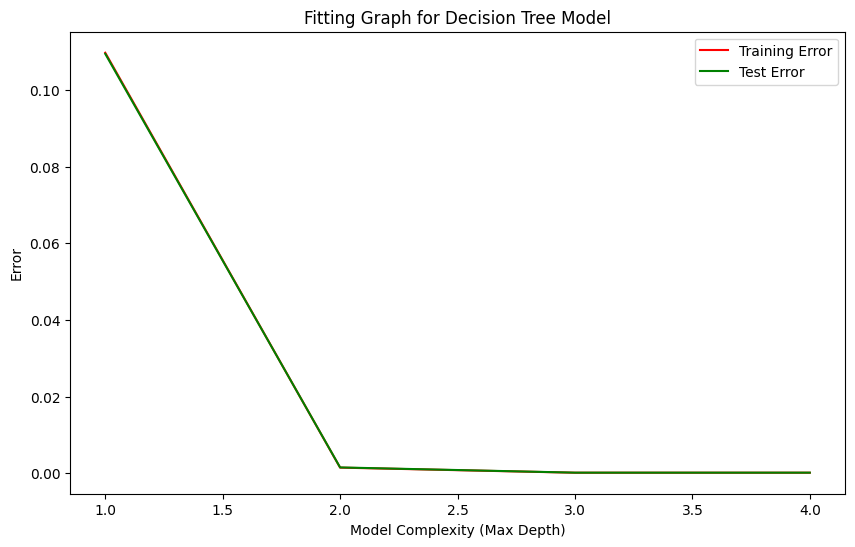

In [70]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

# we can adjust the depth, but since it is a simple model we can start small first and adjust later
max_depths = range(1, 5)  

#create empty list of training and testing errors for plotting
train_errors = []
test_errors = []

# let us first define the Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

for depth in max_depths:
    # creating the Decision Tree model for current depth
    dt_classifier = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features", maxDepth=depth)
    
    # fitting and training model
    model = dt_classifier.fit(hh_train)
    
    # calculating training error for current depth
    train_predictions = model.transform(hh_train)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_error = 1 - train_accuracy
    train_errors.append(train_error)
    
    # calculating test error for current depth
    test_predictions = model.transform(hh_test)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', color='red')
plt.plot(max_depths, test_errors, label='Test Error', color='green')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Error')
plt.title('Fitting Graph for Decision Tree Model')
plt.legend()
plt.show()

The decision tree was able to predict with 99% accuracy whether a house was owned or rented based on the four variables. First group quarters were excluded since they are neither rented or owned. Then ownership was predicted based on house value, house type, household income and year. We are unsure why we get a test accuracy of 100%. We know this must be , but were unable to figure out the cause. This was our initial trial at a decision tree, so we moved on and decided to combine the individual and household dataset to get a better overall picture of someone's ability to own a home. This is accomplished in the next section which is our true Model 2

## Model 2

We originally tried a linear regression model for determining someone's ability to own a home, but found that a decision tree gave better results. Below is the linear regression.

### Without House Value ("AVALUEH")

In [ ]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [76]:
# Create logistic regression model
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")

# Fit the model
model = logistic_regression.fit(hh_norm_train)

# Create predictions of test set
predictions = model.transform(hh_norm_test)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7397
Precision: 0.7310
Recall: 0.7397


### With House Value ("AVALUEH")

In [77]:
new = df_hh.filter(df_hh.OWNERSHP != 0)
feature_columns = ["HHTYPE", "VEHICLES", "NFAMS", "AHHINCOME", "AVALUEH"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(new)
hh_norm_train, hh_norm_test = data.randomSplit(weights=[0.8,0.2], seed=200)

In [78]:
# Create logistic regression model
logistic_regression = LogisticRegression(featuresCol="features", labelCol="OWNERSHP")

# Fit the model
model = logistic_regression.fit(hh_norm_train)

# Create predictions of test set
predictions = model.transform(hh_norm_test)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

#print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


This was part of the reason we preferred sticking with the decision tree, however, we thought it was interesting that adding the feature "AVALUEH," caused the accuracy to jump to 100%. We did not evaluate this any further, so we never came to any conclusions on why this happened.

### Decision Tree using the Comibined Datasets and Household Income

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Assuming result_df is already loaded
new = result_df.filter(result_df.OWNERSHP != 0)

# Define the feature columns
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "AFTOTINC", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

# Assemble feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform features into feature Vector
data = assembler.transform(new)

# Split into train/test data
combined_train, combined_test = data.randomSplit(weights=[0.8,0.2], seed=200)

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")

# Train the model
model = dt.fit(combined_train)

# Make predictions
predictions = model.transform(combined_test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Show predictions
predictions.select("OWNERSHP", "prediction", "probability").show()


Accuracy: 0.779172737138095
+--------+----------+--------------------+
|OWNERSHP|prediction|         probability|
+--------+----------+--------------------+
|       2|       1.0|[0.0,0.8197095863...|
|       1|       1.0|[0.0,0.9000131620...|
|       2|       1.0|[0.0,0.6879655665...|
|       1|       1.0|[0.0,0.8197095863...|
|       1|       1.0|[0.0,0.8356774613...|
|       1|       1.0|[0.0,0.8356774613...|
|       2|       1.0|[0.0,0.5696735194...|
|       2|       1.0|[0.0,0.5696735194...|
|       2|       1.0|[0.0,0.5696735194...|
|       2|       2.0|[0.0,0.3550117156...|
|       1|       1.0|[0.0,0.5783232628...|
|       2|       2.0|[0.0,0.4555812876...|
|       1|       1.0|[0.0,0.6814768759...|
|       1|       1.0|[0.0,0.9000131620...|
|       1|       1.0|[0.0,0.9000131620...|
|       2|       2.0|[0.0,0.3398293465...|
|       2|       1.0|[0.0,0.6879655665...|
|       2|       1.0|[0.0,0.9000131620...|
|       1|       1.0|[0.0,0.6814768759...|
|       1|       1.0|[0.0,

In [19]:
# Print the decision tree model

# Mapping of features
feature_mapping = {
    0: "AGE",
    1: "MARST",
    2: "RACE",
    3: "CITIZEN",
    4: "EDUC",
    5: "CLASSWKR",
    6: "AFTOTINC",
    7: "NFAMS",
    8: "FAMSIZE",
    9: "GQ",
    10: "STATEICP",
    11: "CBPERNUM",
    12: "YEAR",
    13: "HHTYPE"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3f7444867341, depth=5, numNodes=27, numClasses=3, numFeatures=14
  If (AFTOTINC <= 37155.0)
   If (AGE <= 47.5)
    If (AFTOTINC <= 22836.7)
     Predict: Rent
    Else (AFTOTINC > 22836.7)
     If (HHTYPE <= 0.5)
      Predict: Rent
     Else (HHTYPE > 0.5)
      If (HHTYPE <= 3.5)
       Predict: Own
      Else (HHTYPE > 3.5)
       Predict: Rent
   Else (AGE > 47.5)
    If (MARST <= 1.5)
     Predict: Own
    Else (MARST > 1.5)
     If (RACE <= 1.5)
      Predict: Own
     Else (RACE > 1.5)
      If (AFTOTINC <= 14529.8)
       Predict: Rent
      Else (AFTOTINC > 14529.8)
       Predict: Own
  Else (AFTOTINC > 37155.0)
   If (AGE <= 44.5)
    If (FAMSIZE <= 2.5)
     If (HHTYPE <= 3.5)
      If (HHTYPE <= 0.5)
       Predict: Rent
      Else (HHTYPE > 0.5)
       Predict: Own
     Else (HHTYPE > 3.5)
      If (AGE <= 31.5)
       Predict: Rent
      Else (AGE > 31.5)
       Predict: Own
    Else (FAMSIZE > 2.5)
     Predic

### Decision Tree using the Comibined Datasets and withholding Household Income

In [21]:
# Assuming result_df is already loaded
new = result_df.filter(result_df.OWNERSHP != 0)

# Define the feature columns
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

# Assemble feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform features into feature Vector
data = assembler.transform(new)

# Split into train/test data
combined_train, combined_test = data.randomSplit(weights=[0.8,0.2], seed=200)

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features")


# Train the model
model_2 = dt.fit(combined_train)

# Make predictions
predictions = model_2.transform(combined_test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7712686335993348


In [22]:
# Print the decision tree model

# Mapping of features
feature_mapping = {
    0: "AGE",
    1: "MARST",
    2: "RACE",
    3: "CITIZEN",
    4: "EDUC",
    5: "CLASSWKR",
    6: "NFAMS",
    7: "FAMSIZE",
    8: "GQ",
    9: "STATEICP",
    10: "CBPERNUM",
    11: "YEAR",
    12: "HHTYPE"
}
# Mapping of predicted class 
class_mapping = {
    0.0: "Na",
    1.0: "Own",
    2.0: "Rent"
}

# replace feature numbers and predicted class numbers with names and labels
def convert_tree_structure(tree_structure):
    lines = tree_structure.split("\n")
    converted_lines = []
    for line in lines:
        for feature_num, feature_name in feature_mapping.items():
            line = line.replace(f"feature {feature_num} ", f"{feature_name} ")
            line = line.replace(f"feature {feature_num}>", f"{feature_name}>")
            line = line.replace(f"feature {feature_num}<=", f"{feature_name}<=")
        for class_num, class_label in class_mapping.items():
            line = line.replace(f"Predict: {class_num}", f"Predict: {class_label}")
        converted_lines.append(line)
    return "\n".join(converted_lines)

tree_structure = model_2.toDebugString
converted_tree_structure = convert_tree_structure(tree_structure)
print(converted_tree_structure)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e7f44a94e5fc, depth=5, numNodes=37, numClasses=3, numFeatures=13
  If (HHTYPE <= 1.5)
   If (HHTYPE <= 0.5)
    If (AGE <= 41.5)
     If (RACE <= 1.5)
      If (FAMSIZE <= 2.5)
       Predict: Rent
      Else (FAMSIZE > 2.5)
       Predict: Own
     Else (RACE > 1.5)
      Predict: Rent
    Else (AGE > 41.5)
     Predict: Own
   Else (HHTYPE > 0.5)
    If (CITIZEN <= 2.5)
     Predict: Own
    Else (CITIZEN > 2.5)
     If (AGE <= 41.5)
      Predict: Rent
     Else (AGE > 41.5)
      Predict: Own
  Else (HHTYPE > 1.5)
   If (AGE <= 44.5)
    If (HHTYPE <= 3.5)
     If (RACE <= 1.5)
      If (CBPERNUM <= 1.5)
       Predict: Rent
      Else (CBPERNUM > 1.5)
       Predict: Own
     Else (RACE > 1.5)
      If (EDUC <= 9.0)
       Predict: Rent
      Else (EDUC > 9.0)
       Predict: Own
    Else (HHTYPE > 3.5)
     If (AGE <= 29.5)
      If (AGE <= 17.5)
       Predict: Own
      Else (AGE > 17.5)
       Predict: Rent
     Else 

### Evaluation of Decision Tree & Fitting Graph

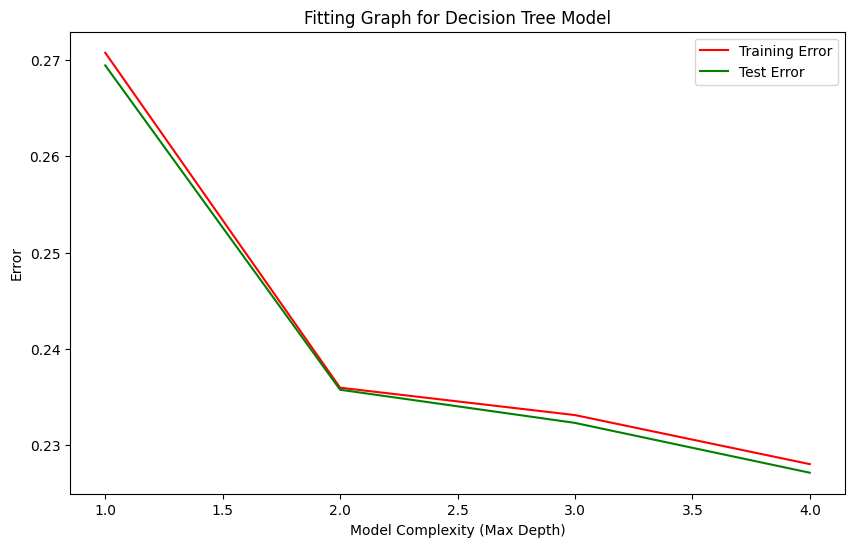

In [81]:
# Assuming result_df is already loaded
new = result_df.filter(result_df.OWNERSHP != 0)

# Define the feature columns
feature_columns = ["AGE", "MARST", "RACE", "CITIZEN", "EDUC", "CLASSWKR", "AFTOTINC", "NFAMS", "FAMSIZE", "GQ", "STATEICP", "CBPERNUM", "YEAR", "HHTYPE"]

# Assemble feature columns into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform features into feature Vector
data = assembler.transform(new)

# Split into train/test data
combined_train, combined_test = data.randomSplit(weights=[0.8,0.2], seed=200)


max_depths = range(1, 5)  

#create empty list of training and testing errors for plotting
train_errors = []
test_errors = []

# let us first define the Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="OWNERSHP", predictionCol="prediction", metricName="accuracy")

for depth in max_depths:
    # creating the Decision Tree model for current depth
    dt = DecisionTreeClassifier(labelCol="OWNERSHP", featuresCol="features", maxDepth=depth)
    
    # fitting and training model
    model = dt.fit(combined_train)

    # calculating training error for current depth
    train_predictions = model.transform(combined_train)
    train_accuracy = evaluator.evaluate(train_predictions)
    train_error = 1 - train_accuracy
    train_errors.append(train_error)
    
    # calculating test error for current depth
    test_predictions = model.transform(combined_test)
    test_accuracy = evaluator.evaluate(test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', color='red')
plt.plot(max_depths, test_errors, label='Test Error', color='green')
plt.xlabel('Model Complexity (Max Depth)')
plt.ylabel('Error')
plt.title('Fitting Graph for Decision Tree Model')
plt.legend()
plt.show()

As the complexity (depth of trees) increases, we do get continue to see an increase in accuracy, however, it is trivial. We can see the best depth to pick is 2. After this, the marginal increase in accuracy is not worth it.